# Re-estimating kmax and krmax ahead of the CLM5PPE
* last update: 24-Sept-2020
* Daniel Kennedy (djk2120@ucar.edu)
* xarray version 15.1

## Goal:
 * define new values for kmax and krmax ahead of the CLM5 parameter perturbation experiment (PPE)
 * choose values to better comport with hydraulic theory
 * but without enacting overly large changes to model climatology
 * noting that we will  likely revist this topic after the PPE
 
## Motivation:
 * anecdotal evidence indicates that kmax and krmax values could be improved
 * especially kmax, which did not feature any PFT variation in CLM5
     * likely that smaller stature PFTs (e.g. grasses) had too high of kmax in CLM5
     
## Methods:
 * run an ensemble of quasi-global CLM5 simulations varying kmax and krmax
 * subset the output to constrain the parameter space to simulations producing reasonable GPP values
 * choose a pair of kmax/krmax from that space, that minimizes a kmax/krmax cost function

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import cartopy.crs as ccrs
import os
import netCDF4

%matplotlib inline

In [43]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.5 (default, Dec 10 2019, 14:55:39) 
[GCC 8.3.0]
python-bits: 64
OS: Linux
OS-release: 3.10.0-1127.13.1.el7.x86_64
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.5
libnetcdf: 4.7.3

xarray: 0.15.1
pandas: 1.0.3
numpy: 1.18.2
scipy: 1.3.2
netCDF4: 1.5.3
pydap: installed
h5netcdf: None
h5py: 2.10.0
Nio: 1.5.5
zarr: 2.4.0
cftime: 1.1.2
nc_time_axis: None
PseudoNetCDF: None
rasterio: 1.1.3
cfgrib: None
iris: 2.4.0
bottleneck: 1.3.2
dask: 2.14.0
distributed: 2.14.0
matplotlib: 3.2.1
cartopy: 0.18.0b2
seaborn: 0.10.0
numbagg: None
setuptools: 46.1.3
pip: 20.1.1
conda: None
pytest: 5.4.1
IPython: 7.13.0
sphinx: 3.0.2


## Optional: add extra workers

In [82]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=18,
                     processes=18, memory="190GB",
                     project='P93300641',
                     walltime='1:00:00')
cluster.scale(18)
client = Client(cluster)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=36,
                     processes=36, memory="109GB",
                     project='P93300041',
                     queue='premium',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='00:45:00')
cluster.scale(36)
client = Client(cluster)

In [85]:
client

Client Scheduler: tcp://10.12.205.14:40844 Dashboard: http://10.12.205.14:41122/status,Cluster Workers: 18 Cores: 18 Memory: 190.08 GB


## EXPERIMENT 1: OAAT sensitivity of GPP to kmax and krmax
 * quasi-global, using a sparse grid
 * using CLM5-bgc
 * 10 year simulations after a 120 year spinup

In [4]:
# LOCATE THE OUTPUT DATA
thedir = '/glade/scratch/djk2120/kmax_ens/sparsegrid/oaatv2/output/'
paths  = sorted(glob.glob(thedir+'run_sg_*h1.nc'))[1:]
ens    = range(len(paths))
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES',
            'BDMS','BDBS','C3ArG','C3G','C4G','C3C']

In [6]:
# LOAD THE OUTPUT DATA
# grab only FPSN and TLAI from all the ensemble members
ens_vars = ['FPSN','TLAI']
def preprocess(ds):
    return ds[ens_vars]
ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',decode_cf=False,
                       preprocess=preprocess,parallel=True)
ds['ens']=ens

# grab one copy of the various extra variables
extra_vars = xr.open_dataset(paths[0],decode_cf=False)
for v in extra_vars.data_vars:
    if v not in ens_vars:
        ds[v]=extra_vars[v]

# redefine the time dimension, CESM time fields are funny
time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                calendar=ds['time'].attrs['calendar'])
ds['time']=xr.DataArray(time_vector,dims='time',attrs=ds['time'].attrs)
ds['pft']=ds['pfts1d_itype_veg'] #reassign pft variable for easier analysis

In [5]:
# Read in the parameter values
pdir = '/glade/scratch/djk2120/kmax_ens/sparsegrid/oaatv2/paramfiles/'
pvars = ['krmax','kmax']
def preprocess(ds):
    return ds[pvars]
ppaths = sorted(glob.glob(pdir+'*.nc'))[1:]
params = xr.open_mfdataset(ppaths,combine='nested',concat_dim='ens',
                           preprocess=preprocess,parallel='True')
params = params.mean(dim='segment')
params['ens'] = ens

In [6]:
#Read in the CLM5 default parameter valueS
basepftfile = '/glade/p/cgd/tss/people/oleson/modify_param/clm5_params.c200402_kwo.c200422.nc'
pvars = ['krmax','kmax','psi50']
defaults    = xr.open_dataset(basepftfile)[pvars].mean(dim='segment')

print('CLM5 parameter default values, by PFT')

x=pd.DataFrame({'pftname':['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3ArG','C3G','C4G','C3C']})
x['krmax']=defaults['krmax'][:16].values
x['kmax']=defaults['kmax'][:16].values
x['psi50']=defaults['psi50'][:16].values
x


CLM5 parameter default values, by PFT


,pftname,krmax,kmax,psi50
0,BG,0.000000e+00,0.000000e+00,-175000.0
1,NEMT,1.000000e-11,2.000000e-08,-530000.0
2,NEBT,1.995262e-10,2.000000e-08,-400000.0
3,NDBT,3.162278e-10,2.000000e-08,-380000.0
4,BETT,6.309573e-09,2.000000e-08,-250000.0
5,BEMT,3.981072e-09,2.000000e-08,-270000.0
6,BDTT,7.943282e-09,2.000000e-08,-340000.0
7,BDMT,3.981072e-09,2.000000e-08,-270000.0
8,BDBT,1.995262e-08,2.000000e-08,-200000.0
9,BES,1.995262e-10,2.000000e-08,-400000.0


In [9]:
#compute average GPP over the ten-year simulation, by PFT for each ensemble member
gpp = ds['FPSN'].groupby('pft').mean(dim=['pft','time'])

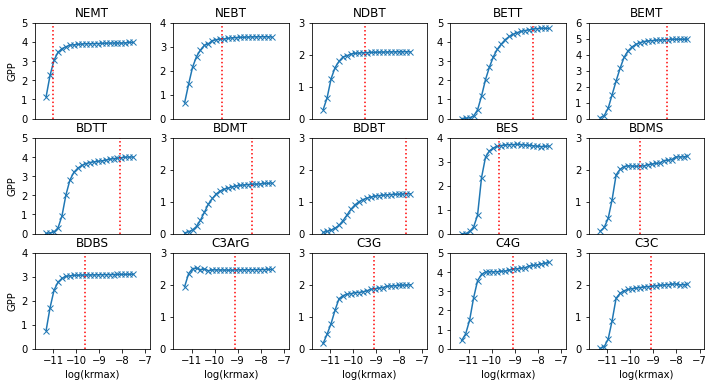

In [10]:
#PLOT THE RESPONSE OF GPP TO VARYING KRMAX, BY PFT
plt.figure(figsize=[12,6])
for pp in np.arange(15)+1:
    plt.subplot(3,5,pp)
    x0 = np.log(defaults['krmax'].sel(pft=pp).values)/np.log(10)
    x = params['krmax'].sel(pft=pp).values
    y = gpp.sel(pft=pp).values
    plt.plot(np.log(x)/np.log(10),y,'-x')
    yy = np.max([3,1+np.floor(1.05*np.max(y))])
    plt.ylim([0,yy])
    plt.yticks(np.arange(yy+1))
    plt.xlim([-11.8,-6.8])
    plt.plot([x0,x0],[0,yy],'r:')
    plt.title(pftnames[pp])
    if (pp==1)|(pp==6)|(pp==11):
        plt.ylabel('GPP')
    if pp>10:
        plt.xlabel('log(krmax)')
        plt.xticks(-11+np.arange(5))
    else:
        plt.xticks([])
plt.subplots_adjust(hspace=0.2)


### Comments on the plot above...
 - the blue curve plots GPP from an ensemble of simulations, varying krmax, for the 15 natural vegetation types
 - the red lines indicate the CLM5 default value of krmax
 - most of these curves are highly saturating, (especially considering log x-axis)
 - our instinct is that the values we choose for CLM5.1 should not be very far out on the saturated part of the curve
 - mainly because this would require an investment of carbon to develop the xylem, without much or any return through GPP
 - the situation is the same for kmax

## EXPERIMENT2, matrix of kmax and krmax simulations
 * quasi-global, using a sparse grid
 * using CLM5-bgc
 * 10 year simulations after a 120 year spinup
 * here we vary both kmax and krmax

In [7]:
#PFT level output
thedir = '/glade/scratch/djk2120/kmax_ens/sparsegrid/oaatv3/output/'
paths  = sorted(glob.glob(thedir+'run_sg_*h1.nc'))
ens    = range(len(paths))
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES',
            'BDMS','BDBS','C3ArG','C3G','C4G','C3C']

In [8]:
%%time 
# grab only FPSN and TLAI from all the ensemble members
ens_vars = ['FPSN','TLAI']
def preprocess(ds):
    return ds[ens_vars]
ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',decode_cf=False,
                       preprocess=preprocess,parallel=True)
ds['ens']=ens

# grab one copy of the various extra variables
extra_vars = xr.open_dataset(paths[0],decode_cf=False)
for v in extra_vars.data_vars:
    if v not in ens_vars:
        ds[v]=extra_vars[v]

# redefine the time dimension, CESM time fields are funny
time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                calendar=ds['time'].attrs['calendar'])
ds['time']=xr.DataArray(time_vector,dims='time',attrs=ds['time'].attrs)
ds['pft']=ds['pfts1d_itype_veg'] #reassign pft variable for easier analysis

CPU times: user 548 ms, sys: 48.1 ms, total: 596 ms
Wall time: 900 ms


In [9]:
# Read in the parameter values for the full ensemble
pdir = '/glade/scratch/djk2120/kmax_ens/sparsegrid/oaatv3/paramfiles/'
pvars = ['krmax','kmax']
def preprocess(ds):
    return ds[pvars]
ppaths = sorted(glob.glob(pdir+'*.nc'))
params = xr.open_mfdataset(ppaths,combine='nested',concat_dim='ens',
                           preprocess=preprocess,parallel='True')
params = params.mean(dim='segment')
params['ens'] = ens

In [10]:
gpp = ds['FPSN'].mean(dim='time').groupby('pft').mean().load()

In [11]:
#resample gpp into kmax x krmax, both increasing
gpp_grid = np.zeros([16,10,8])
kmax  = params['kmax'].sel(pft=1).values
krmax = params['krmax'].sel(pft=1).values
k  = sorted(np.unique(kmax))
kr = sorted(np.unique(krmax))
for i in range(10):
    for j in range(8):
        ix1 = kmax==k[i]
        ix2 = krmax==kr[j]
        ix  = np.logical_and(ix1,ix2)
        for pp in 1+np.arange(15):
            gpp_grid[pp,i,j] = gpp.sel(pft=pp).isel(ens=ix)

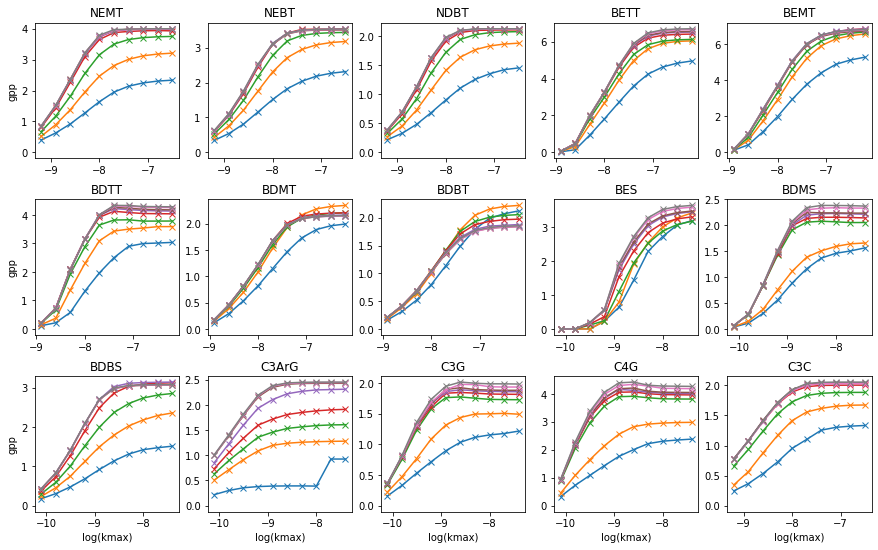

In [12]:
plt.figure(figsize=[15,9])
for pp in np.arange(15)+1:
    plt.subplot(3,5,pp)
    k  = np.unique(params['kmax'].sel(pft=pp))
    plt.plot(np.log(k)/np.log(10),gpp_grid[pp,:,:],'-x')
    gmax = np.max(gpp_grid[pp,:,:])
    plt.ylim([-0.05*gmax,1.05*gmax])
    plt.title(pftnames[pp])
    if (pp==1)|(pp==6)|(pp==11):
        plt.ylabel('gpp')
    if pp>10:
        plt.xlabel('log(kmax)')
plt.subplots_adjust(hspace=0.3)

### Comments on the plot above...
 - each curve represents a different value of krmax
 - we are varying kmax and krmax, to understand the GPP response surface to these 2 params
 - notice that there are clear interactions, i.e. the curves aren't just translated up and down
 - the blue C3ArG has a known scripting bug, but it was so far out of the reasonable range that we don't go back and re-run those simulations
 - an alternative plotting approach is to go 3d, which we opt for in the next analysis

### Main task: choose new values for kmax and krmax for each natural PFT
 - choose the combination of kmax/krmax that lies within an appropriate segment of the curve w.r.t. saturation, and also minimizes a kmax/krmax cost function
 - four steps:
     1. constrain and normalize the domains of kmax and krmax
         * to help account for differences in the parameter ranges used, we constrain the low-side of the domains to 20% of saturation
         * in the future, I would probably consider doing the high side as well
     2. interpolate the ensemble output to get more samples of kmax/krmax
     3. determine where in the domain is acceptable, based on GPP saturation
     4. determine where in that area minimizes our cost function

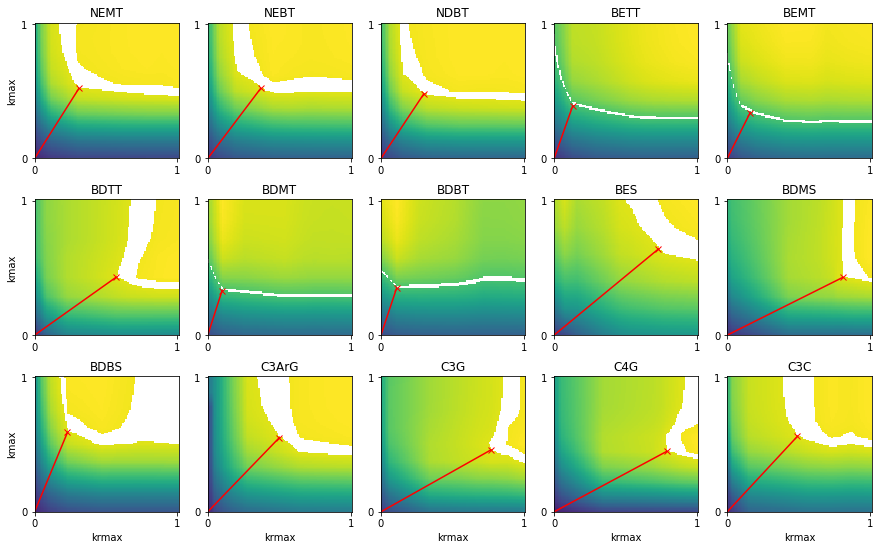

In [117]:
# FIND THE OPTIMAL values for kmax and krmax
#   *** some functions are needed from lower cells
ttvals = np.zeros(16)+0.95
ix2 = [4,5,7,8]
ttvals[ix2]=0.7

newkvals  = np.zeros(16)
newkrvals = np.zeros(16)
newgvals  = np.zeros(16)
plt.figure(figsize=[15,9])
for pp in 1+np.arange(15):
    kmax  = params['kmax'].sel(pft=pp).values
    krmax = params['krmax'].sel(pft=pp).values
    gv    = gpp.sel(pft=pp).values
    gn    = gv/np.max(gv)

    x,y,g,k,r = constrain_domain(kmax,krmax,gn)
    g_kmax    = interp1(x,y,g)
    g_both    = interp2(y,g_kmax)
    
    tt = ttvals[pp]
    i,j       = bestk(g_both,tt,tt+0.03)

    newkvals[pp]  = k(i)
    newkrvals[pp] = r(j)
    newgvals[pp]  = tt*np.max(gv)
    
    ix = np.logical_and(g_both>tt,g_both<tt+0.03)
    g_both[ix] = np.nan

    plt.subplot(3,5,pp)
    plt.pcolormesh(np.arange(102)/100,np.arange(102)/100,g_both,vmin=0,vmax=1)
    plt.plot([0,j/100],[0,i/100],'r-')
    plt.plot(j/100,i/100,'rx')
    plt.title(pftnames[pp])
    if (pp==1)|(pp==6)|(pp==11):
        plt.ylabel('kmax')
    if pp>10:
        plt.xlabel('krmax')
    plt.yticks([0,1])
    plt.xticks([0,1])

    
plt.subplots_adjust(hspace=0.3)

### Comments on the plot above...
 - the color in each plot represents GPP for a given value of kmax/krmax
 - dark blue is zero, bright yellow is the maximum GPP seen from that PFT across the ensemble
 - I nan'd out the region of acceptable solutions, creating the white contour
     * see below for more details
 - Our kmax/krmax cost function seeks to minimize the distance to the origin of these plots
     * this serves to pick relatively small values for both kmax and krmax
     * because we constrained and normalized the domains, we think this is a fair metric balancing kmax with krmax

 

## How did I choose the GPP thresholds?
 * the motivation here was to shift the PHS params to a more scientifically reasonable portion of the response surface
 * not to necessarily improve model-obs at this time
 * we intend to revisit this question after the PPE, when we will have more information to consider parameter estimation
 * with that in mind, we wanted to choose GPP thresholds that:
     1. were not very complicated, i.e. a fixed percentage ideally for all PFTs
     2. avoided large changes in model climatology
 * as a compromise we use two GPP thresholds:
     * 0.95 for most PFTs
     * 0.7 for BETT,BEMT,BDMT,BDBT
 * otherwise we were very biased on one or both groups

In [18]:
#get CLM5 default output
afile = '/glade/scratch/djk2120/kmax_ens/sparsegrid/oaatv2/output/run_sg_v2_clm50dhcp_oaatv2_000_h1.nc'
clm5 = xr.open_dataset(afile,decode_cf=False)
clm5['pft']=clm5['pfts1d_itype_veg']
time_vector = cftime.num2date(clm5['time'].values-16,units=clm5['time'].attrs['units'],
                calendar=clm5['time'].attrs['calendar'])
clm5['time']=xr.DataArray(time_vector,dims='time',attrs=clm5['time'].attrs)

[1.0259116]


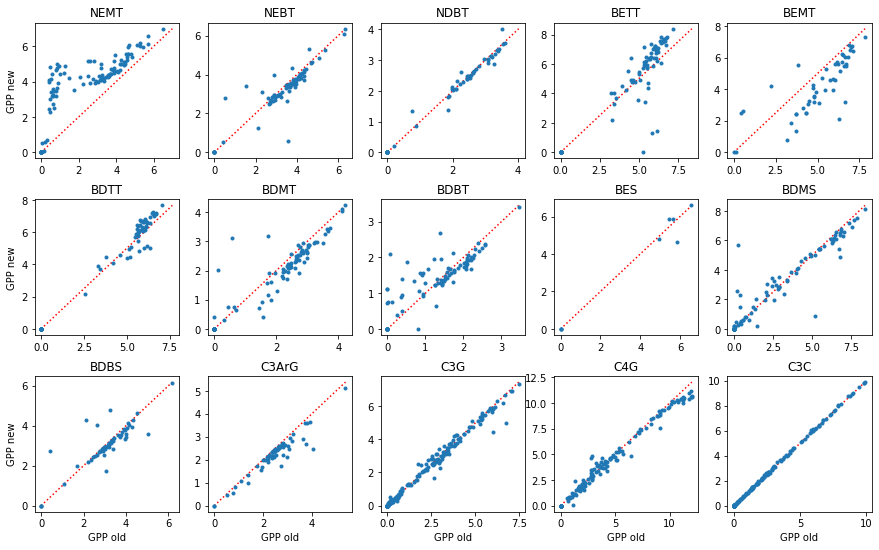

In [19]:
#PLOT up GPP from CLM5 and what we might expect from CLM5.1
plt.figure(figsize=[15,9])
for pp in 1+np.arange(15):
    plt.subplot(3,5,pp)

    kk  = newkvals[pp]
    xx  = abs(params['kmax'].sel(pft=pp).values-kk)
    ix1 = xx==np.min(xx)
    kk  = newkrvals[pp]
    xx  = abs(params['krmax'].sel(pft=pp).values-kk)
    ix2 = xx==np.min(xx)

    ix = np.logical_and(ix1,ix2)
    y1 = ds['FPSN'].isel(ens=ix).sel(pft=pp).mean(dim='time').values.ravel()
    y2 = clm5['FPSN'].sel(pft=pp).mean(dim='time')
    iav1 = ds['FPSN'].isel(ens=ix).sel(pft=pp).groupby('time.year').mean(dim='time').std(dim='year').mean(dim='pft')
    iav2 = clm5['FPSN'].sel(pft=pp).groupby('time.year').mean(dim='time').std(dim='year').mean(dim='pft')
    ymax = np.max([np.max(y1),np.max(y2)])
    plt.plot([0,ymax],[0,ymax],'r:')
    plt.plot(y2,y1,'.')
    plt.title(pftnames[pp])
    if (pp==1)|(pp==6)|(pp==11):
        plt.ylabel('GPP new')
    if pp>10:
        plt.xlabel('GPP old')
    if pp==13:
        print(iav1.values/iav2.values)
plt.subplots_adjust(hspace=0.3)

### Comments on the plot above...
 - x-axis is GPP from the CLM5 default
 - y-axis is GPP from the ensemble member closest to our chosen kmax/krmax
     * note that this may be slightly different than the ensemble member
     * we are running the new paramset, but opted for a full global run, found below [zqz]
 - the PFT with the largest change is NEMT, which featured a very low krmax in CLM5
 - BES are not very well-sampled in this sparsegrid, so I'm a bit worried about that one

 

### How did this process change kmax/krmax?

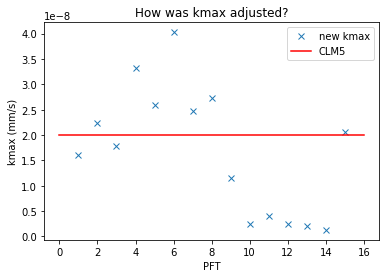

In [21]:
plt.plot(1+np.arange(15),newkvals[1:],'x')
plt.plot([0,16],[2e-8,2e-8],'r-')
plt.legend(['new kmax','CLM5'])
plt.ylabel('kmax (mm/s)')
plt.xlabel('PFT')
plt.title('How was kmax adjusted?');

In [22]:
k1 = newkvals[1:]
k2 = defaults['kmax'][1:16].values

print('how many times higher or lower is the new kmax relative to CLM5?')
print(' ')

x=pd.DataFrame({'pftname':['NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3ArG','C3G','C4G','C3C']})
yy = list(k1/k2)
for i,y in zip(range(len(yy)),yy):
    if y<1:
        yy[i]=''
x['new kmax is larger by']=yy
yy = list(k2/k1)
for i,y in zip(range(len(yy)),yy):
    if y<1:
        yy[i]=''
x['old kmax is larger by']=yy
x


how many times higher or lower is the new kmax relative to CLM5?
 


,pftname,new kmax is larger by,old kmax is larger by
0,NEMT,,1.24833
1,NEBT,1.11729,
2,NDBT,,1.11729
3,BETT,1.65864,
4,BEMT,1.30134,
5,BDTT,2.01391,
6,BDMT,1.23971,
7,BDBT,1.36604,
8,BES,,1.7411
9,BDMS,,7.94474


In [42]:
k1 = newkrvals[1:]
k2 = defaults['krmax'][1:16].values

print('how many times higher or lower is the new krmax relative to CLM5?')
print(' ')

x=pd.DataFrame({'pftname':['NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3ArG','C3G','C4G','C3C']})
yy = list(k1/k2)
for i,y in zip(range(len(yy)),yy):
    if y<1:
        yy[i]=''
x['new krmax is larger by']=yy
yy = list(k2/k1)
for i,y in zip(range(len(yy)),yy):
    if y<1:
        yy[i]=''
x['old krmax is larger by']=yy
x


how many times higher or lower is the new krmax relative to CLM5?
 


,pftname,new krmax is larger by,old krmax is larger by
0,NEMT,14.9274,
1,NEBT,,1.27265
2,NDBT,,2.93495
3,BETT,,37.9876
4,BEMT,,47.6648
5,BDTT,,2.33329
6,BDMT,,38.3611
7,BDBT,,143.135
8,BES,5.15549,
9,BDMS,150.298,


## Setting min/max values for the PPE

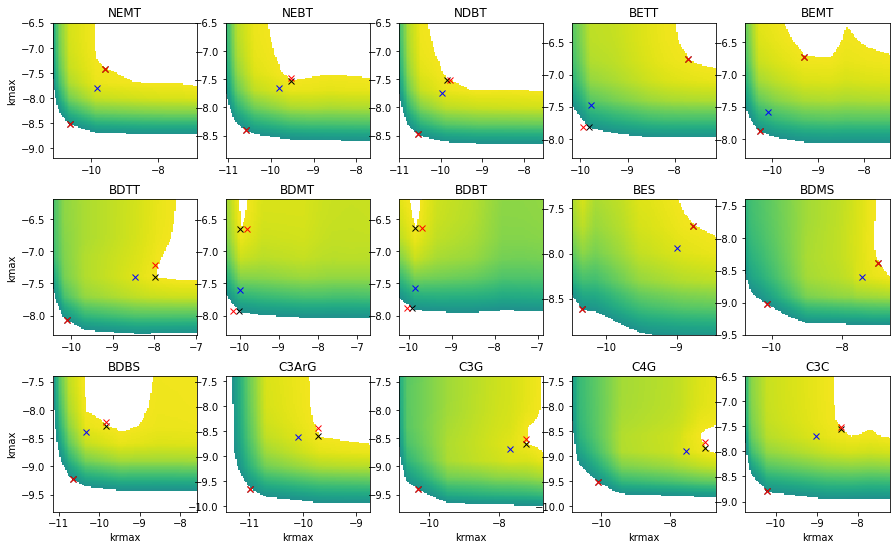

In [118]:
# FIND THE OPTIMAL values for kmax and krmax
#   *** some functions are needed from lower cells

if newkrvals.size==16:
    newkrvals = newkrvals[1:]
    newkvals = newkvals[1:]

hival = 0.98
loval = 0.5

lokvals  = np.zeros(15)
lokrvals = np.zeros(15)
hikvals  = np.zeros(15)
hikrvals = np.zeros(15)

plt.figure(figsize=[15,9])
for pp in 1+np.arange(15):
    kmax  = params['kmax'].sel(pft=pp).values
    krmax = params['krmax'].sel(pft=pp).values
    gv    = gpp.sel(pft=pp).values
    gn    = gv/np.max(gv)

    x,y,g,k,r = constrain_domain(kmax,krmax,gn)
    g_kmax    = interp1(x,y,g)
    g_both    = interp2(y,g_kmax)
    
    i1,j1          = bestk(g_both,loval,1)
    if newkvals[pp-1]/k(i1)>1.5:
        lokvals[pp-1]  = k(i1)
    else:
        lokvals[pp-1]  = newkvals[pp-1]/1.5 
    if newkrvals[pp-1]/r(j1)>1.5:
        lokrvals[pp-1]  = r(j1)
    else:
        lokrvals[pp-1]  = newkrvals[pp-1]/1.5
        

    
    i2,j2          = bestk(g_both,hival,1)
    if k(i2)/newkvals[pp-1]>1.5:
        hikvals[pp-1]  = k(i2)
    else:
        hikvals[pp-1]  = 1.5*newkvals[pp-1]
    if r(j2)/newkrvals[pp-1]>1.5:
        hikrvals[pp-1]  = r(j2)
    else:
        hikrvals[pp-1]  = 1.5*newkrvals[pp-1]

    
    
    ix = np.logical_or(g_both<loval,g_both>hival)
    g_both[ix] = np.nan

    plt.subplot(3,5,pp)
    plt.pcolormesh(np.log10(r(np.arange(101))),np.log10(k(np.arange(101))),g_both,vmin=0,vmax=1)
    plt.plot(np.log10(r(j1)),np.log10(k(i1)),'kx')
    plt.plot(np.log10(r(j2)),np.log10(k(i2)),'kx')
    plt.plot(np.log10(lokrvals[pp-1]),np.log10(lokvals[pp-1]),'rx')
    plt.plot(np.log10(hikrvals[pp-1]),np.log10(hikvals[pp-1]),'rx')
    plt.plot(np.log10(newkrvals[pp-1]),np.log10(newkvals[pp-1]),'bx')
    plt.title(pftnames[pp])
    if (pp==1)|(pp==6)|(pp==11):
        plt.ylabel('kmax')
    if pp>10:
        plt.xlabel('krmax')


    
plt.subplots_adjust(hspace=0.3)

In [140]:
def siground(x):
    xret = x.copy()
    logx = np.log10(x)
    for i in -13+np.arange(7):
        ix = np.logical_and(logx>i,logx<=i+1)
        if np.sum(ix)>0:
            xvals = x[ix]
            xret[ix]= np.round(xvals/10.**(i-1))*10.**(i-1)

    return xret



In [147]:
lokvals = siground(lokvals)
lokrvals = siground(lokrvals)
hikvals = siground(hikvals)
hikrvals = siground(hikrvals)

In [160]:
x=pd.DataFrame({'pftname':pftnames[1:]})
x['krmax-']   = lokrvals
x['krmaxdef'] = newkrvals
x['krmax+']   = hikrvals
x

,pftname,krmax-,krmaxdef,krmax+
0,NEMT,2.300000e-11,1.492742e-10,2.500000e-10
1,NEBT,2.600000e-11,1.567796e-10,2.900000e-10
2,NDBT,2.800000e-11,1.077457e-10,1.600000e-10
3,BETT,1.100000e-10,1.660956e-10,1.900000e-08
4,BEMT,5.400000e-11,8.352224e-11,5.100000e-10
5,BDTT,8.000000e-11,3.404328e-09,1.000000e-08
6,BDMT,6.900000e-11,1.037788e-10,1.600000e-10
7,BDBT,9.300000e-11,1.393969e-10,2.100000e-10
8,BES,4.500000e-11,1.028656e-09,1.700000e-09
9,BDMS,7.400000e-11,3.775307e-08,1.100000e-07


In [165]:
lokvals

array([3.0e-09, 4.0e-09, 3.4e-09, 1.5e-08, 1.3e-08, 8.5e-09, 1.2e-08,
       1.3e-08, 2.4e-09, 9.5e-10, 5.9e-10, 2.3e-10, 4.0e-10, 3.1e-10,
       1.6e-09])

In [164]:
x=pd.DataFrame({'pftname':pftnames[1:]})
x['kmax-']   = lokvals
x['kmaxdef'] = newkvals
x['kmax+']   = hikvals
x

,pftname,kmax-,kmaxdef,kmax+
0,NEMT,3.000000e-09,1.602140e-08,3.800000e-08
1,NEBT,4.000000e-09,2.234574e-08,3.400000e-08
2,NDBT,3.400000e-09,1.790050e-08,3.100000e-08
3,BETT,1.500000e-08,3.317278e-08,1.700000e-07
4,BEMT,1.300000e-08,2.602684e-08,1.900000e-07
5,BDTT,8.500000e-09,4.027822e-08,6.000000e-08
6,BDMT,1.200000e-08,2.479415e-08,2.200000e-07
7,BDBT,1.300000e-08,2.732081e-08,2.300000e-07
8,BES,2.400000e-09,1.148698e-08,2.000000e-08
9,BDMS,9.500000e-10,2.517389e-09,4.100000e-09


In [163]:
hikvals

array([3.8e-08, 3.4e-08, 3.1e-08, 1.7e-07, 1.9e-07, 6.0e-08, 2.2e-07,
       2.3e-07, 2.0e-08, 4.1e-09, 6.2e-09, 3.6e-09, 3.0e-09, 1.9e-09,
       3.1e-08])

In [55]:
x=pd.DataFrame({'pftname':pftnames})
x['K- smaller by'] = newkvals/lokvals
x['K+ larger by']  = hikvals/newkvals
x

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,pftname,K- smaller by,K+ larger by
0,BG,NaN,NaN
1,NEMT,5.388934,2.394957
2,NEBT,5.578975,1.319508
3,NDBT,5.278032,1.741101
4,BETT,2.173470,5.205367
5,BEMT,1.972465,7.310652
6,BDTT,4.723971,1.000000
7,BDMT,2.070530,8.876556
8,BDBT,2.070530,8.456144
9,BES,4.756828,1.741101


## Some functions I need for the optimization scheme

In [13]:
def constrain_domain(kmax,krmax,gpp_norm):
    x = kmax.copy()
    y = krmax.copy()
    xvals = np.unique(x)
    for xx in xvals:
        ixk = x==xx
        if (np.max(gpp_norm[ixk])<0.2):
            gpp_norm = gpp_norm[~ixk]
            x = x[~ixk]
            y = y[~ixk]
            kmax = kmax[~ixk]
            krmax = krmax[~ixk]

    yvals = np.unique(y)
    for yy in yvals:
        ixk = y==yy
        if (np.max(gpp_norm[ixk])<0.2):
            gpp_norm = gpp_norm[~ixk]
            x = x[~ixk]
            y = y[~ixk]            
            kmax = kmax[~ixk]
            krmax = krmax[~ixk]
            
    x = np.log(x)
    x = x-min(x)
    x = x/max(x)

    y = np.log(y)
    y = y-min(y)
    y = y/max(y)

    def kmap(i):
        k1 = np.log(np.min(kmax))
        k2 = np.log(np.max(kmax))
        logk  = k1+(i/100)*(k2-k1)
        k     = np.exp(logk)
        return k
    
    def krmap(j):
        k1 = np.log(np.min(krmax))
        k2 = np.log(np.max(krmax))
        logk  = k1+(j/100)*(k2-k1)
        k     = np.exp(logk)
        return k
        
            
    return x,y,gpp_norm,kmap,krmap

In [14]:
def interp1(kmax,krmax,gpp):
    rvals = np.unique(krmax)
    nr   = len(rvals)
    yout = np.zeros([101,nr])
    for i in range(nr):
        ix = krmax==rvals[i]

        k = kmax[ix]
        g = gpp[ix]
        ixs = np.argsort(k)

        thisk = k[ixs]
        thisg = g[ixs]
        kk = 0
        for j in range(101):
            x = j/100

            if x>thisk[kk+1]:
                kk +=1

            y = thisg[kk]+(x-thisk[kk])/(thisk[kk+1]-thisk[kk])*(thisg[kk+1]-thisg[kk])
            yout[j,i] = y
        
    return yout
    

In [15]:
def interp2(krmax,gpp):
    gout = np.zeros([101,101])
    rvals = np.unique(krmax)
    
    for i in range(101):
        rr = 0
        for j in range(101):
            x = j/100
            if x>rvals[rr+1]:
                rr +=1
            g0 = gpp[i,rr]
            g1 = gpp[i,rr+1]
            y = g0+(x-rvals[rr])/(rvals[rr+1]-rvals[rr])*(g1-g0)
            gout[i,j]=y

    return gout

In [16]:
def bestk(gpp,minval,maxval):
    ix = np.logical_and(gpp>minval,gpp<maxval)
    
    i = np.tile(np.arange(101).reshape([-1,1]),101)
    j = i.copy().T
    
    i[~ix] = 200
    j[~ix] = 200
    bb = i**2+j**2
    bbmin = np.min(bb)
    ixb = bb==bbmin
    ii = np.min(i[ixb])
    jj = np.min(j[ixb])
    
    return ii,jj

In [28]:
#write out the new paramfile
outdir  = '/glade/u/home/djk2120/params/pyth/sparsegrid/'
newfile = outdir+'clm5_params.c200624_kwo.c200904.PHS.nc'
basepftfile = '/glade/p/cgd/tss/people/oleson/modify_param/clm5_params.c200624_kwo.c200904.nc'
cmd = 'cp '+basepftfile+' '+newfile
os.system(cmd)        
dset = netCDF4.Dataset(newfile,'r+')
dset['kmax'][:,1:16]=newkvals[1:]
dset['krmax'][1:16]=newkrvals[1:]
dset.close() 